Step 1: Load and Merge the Raw CSVs

In [8]:
!pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


--- Step 1: Loading, Merging & Scaling ---
Loading vitals...
Loading actions...
Merging timeline...
Filtered Dataset: 1385827 rows from 24383 patients.

Generating Clinician Policy 3D Plot...


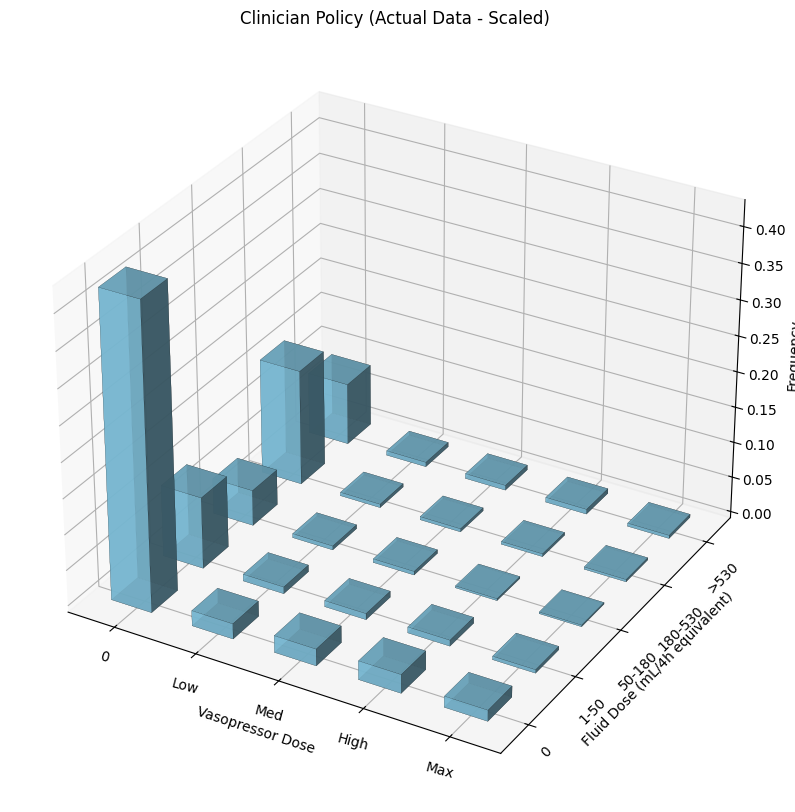

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
EXPORT_DIR = 'data_extraction/'

print("--- Step 1: Loading, Merging & Scaling ---")

# 1. Load Demographics
demog = pd.read_csv(os.path.join(EXPORT_DIR, 'demog.csv'), sep='|')
demog = demog[demog['age'] > 18]
outcome_map = demog.set_index('icustay_id')['morta_hosp'].apply(lambda x: -100 if x == 1 else 100).to_dict()

# 2. Load Vitals
print("Loading vitals...")
vital_files = sorted([f for f in os.listdir(EXPORT_DIR) if f.startswith('ce') and f.endswith('.csv')])
vital_dfs = []
for f in vital_files:
    chunk = pd.read_csv(os.path.join(EXPORT_DIR, f), sep='|')
    vital_dfs.append(chunk)
vitals_raw = pd.concat(vital_dfs, ignore_index=True)

# Pivot Vitals
vitals_raw['feature'] = 'other'
vitals_raw.loc[vitals_raw['itemid'].isin([211,220045]), 'feature'] = 'HR'
vitals_raw.loc[vitals_raw['itemid'].isin([51,442,455,6701,220179,220050]), 'feature'] = 'SysBP'
vitals_raw.loc[vitals_raw['itemid'].isin([646,220277]), 'feature'] = 'SpO2'
vitals_proc = vitals_raw[vitals_raw['feature'] != 'other']
vitals_pivot = vitals_proc.pivot_table(index=['icustay_id', 'charttime'], columns='feature', values='valuenum', aggfunc='mean').reset_index()

# 3. Load Actions
print("Loading actions...")
fluid_mv = pd.read_csv(os.path.join(EXPORT_DIR, 'fluid_mv.csv'), sep='|')
fluid_cv = pd.read_csv(os.path.join(EXPORT_DIR, 'fluid_cv.csv'), sep='|')
fluids = pd.concat([fluid_mv, fluid_cv])
fluids = fluids.groupby(['icustay_id', 'charttime'])['amount'].sum().reset_index().rename(columns={'amount': 'fluid_input'})

vaso_mv = pd.read_csv(os.path.join(EXPORT_DIR, 'vaso_mv.csv'), sep='|')
vaso_cv = pd.read_csv(os.path.join(EXPORT_DIR, 'vaso_cv.csv'), sep='|')
vaso = pd.concat([vaso_mv, vaso_cv])
vaso = vaso.groupby(['icustay_id', 'charttime'])['rate_std'].max().reset_index().rename(columns={'rate_std': 'vaso_input'})

# 4. Merge
print("Merging timeline...")
df_main = vitals_pivot.merge(fluids, on=['icustay_id', 'charttime'], how='left')
df_main = df_main.merge(vaso, on=['icustay_id', 'charttime'], how='left')
df_main['fluid_input'] = df_main['fluid_input'].fillna(0)
df_main['vaso_input'] = df_main['vaso_input'].fillna(0)

# Forward fill vitals
df_main = df_main.sort_values(['icustay_id', 'charttime'])
df_main[['HR', 'SysBP', 'SpO2']] = df_main.groupby('icustay_id')[['HR', 'SysBP', 'SpO2']].ffill()
df_main = df_main.dropna(subset=['HR', 'SysBP', 'SpO2'])
df_main['outcome_reward'] = df_main['icustay_id'].map(outcome_map)
df_main = df_main.dropna(subset=['outcome_reward'])

# --- NEW: CRITICAL DATA FIXES ---

# A. Scale Fluids to match 4-hour buckets
# Since our data is 1-hour, we multiply by 4 to estimate "Rate per 4 hours"
# This aligns our numbers with the Nature paper thresholds (e.g. >530mL/4h)
df_main['fluid_input'] = df_main['fluid_input'] * 4 

# B. Filter "Boring" Recovery Data
# We keep only the first 72 hours (Critical Phase). 
# This removes the long tail of (0,0) actions during recovery.
df_main['step'] = df_main.groupby('icustay_id').cumcount()
df_main = df_main[df_main['step'] <= 72]

# C. Sepsis Filter (Keep Sick Patients)
patient_stats = df_main.groupby('icustay_id').agg({'vaso_input': 'max', 'fluid_input': 'sum'})
sick_patients = patient_stats[(patient_stats['vaso_input'] > 0.05) | (patient_stats['fluid_input'] > 2000)].index
df_main = df_main[df_main['icustay_id'].isin(sick_patients)]

print(f"Filtered Dataset: {len(df_main)} rows from {df_main['icustay_id'].nunique()} patients.")

# --- PLOT CLINICIAN POLICY ---
print("\nGenerating Clinician Policy 3D Plot...")

# Bins matching Nature Paper (Now that fluids are scaled, these bins work!)
f_cond = [(df_main['fluid_input'] > 530), (df_main['fluid_input'] > 180), (df_main['fluid_input'] > 50), (df_main['fluid_input'] > 0)]
f_bin = np.select(f_cond, [4, 3, 2, 1], default=0)

v_cond = [(df_main['vaso_input'] > 0.45), (df_main['vaso_input'] > 0.22), (df_main['vaso_input'] > 0.08), (df_main['vaso_input'] > 0)]
v_bin = np.select(v_cond, [4, 3, 2, 1], default=0)

fluid_labels = ["0", "1-50", "50-180", "180-530", ">530"]
vaso_labels = ["0", "Low", "Med", "High", "Max"]

# Calculate Frequency (Vaso on X, Fluid on Y)
hist, xedges, yedges = np.histogram2d(v_bin, f_bin, bins=[np.arange(6)-0.5, np.arange(6)-0.5], density=True)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='skyblue', alpha=0.8, edgecolor='k', linewidth=0.1)
ax.set_title("Clinician Policy (Actual Data - Scaled)")
ax.set_xlabel("Vasopressor Dose")
ax.set_ylabel("Fluid Dose (mL/4h equivalent)")
ax.set_zlabel("Frequency")
ax.set_xticks(np.arange(5))
ax.set_xticklabels(vaso_labels, rotation=-15)
ax.set_yticks(np.arange(5))
ax.set_yticklabels(fluid_labels, rotation=45)

plt.show()

In [3]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# --- CONFIGURATION ---
if 'df_main' not in locals():
    raise ValueError("df_main is missing! Please run Step 1 first.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Step 2: Processing with Tuned Penalties (Target: {device}) ---")

# 1. Discretize Actions (Standard Nature Paper Bins)
f_cond = [(df_main['fluid_input'] > 530), (df_main['fluid_input'] > 180), (df_main['fluid_input'] > 50), (df_main['fluid_input'] > 0)]
f_bin = np.select(f_cond, [4, 3, 2, 1], default=0)

v_cond = [(df_main['vaso_input'] > 0.45), (df_main['vaso_input'] > 0.22), (df_main['vaso_input'] > 0.08), (df_main['vaso_input'] > 0)]
v_bin = np.select(v_cond, [4, 3, 2, 1], default=0)

df_main['action'] = f_bin * 5 + v_bin

# 2. Normalize State
state_cols = ['HR', 'SysBP', 'SpO2']
for col in state_cols:
    df_main[col] = (df_main[col] - df_main[col].mean()) / (df_main[col].std() + 1e-5)

# 3. Create Transitions with SMOOTHER PENALTY
transitions = []
grouped = df_main.groupby('icustay_id')

for _, group in tqdm(grouped, desc="Generating Trajectories"):
    group = group.reset_index(drop=True)
    if len(group) < 2: continue
        
    states_np = group[state_cols].values.astype(np.float32)
    actions_np = group['action'].values.astype(np.int64)
    out_reward = group['outcome_reward'].values[0]
    
    # --- STRATEGY: OVERSAMPLE DEATHS ---
    repeat_count = 5 if out_reward == -100 else 1
    
    curr_s = states_np[:-1]
    next_s = states_np[1:]
    acts = actions_np[:-1]
    
    # --- NEW STRATEGY: NON-LINEAR PENALTY ---
    # Instead of linear penalty, we use squared penalty to punish MAX doses more
    # Unpack action to get fluid/vaso levels
    fluid_lvl = acts // 5
    vaso_lvl = acts % 5
    
    # Penalty is higher for high doses (quadratic)
    # This encourages the AI to use "just enough" drug, not "max" drug
    penalty = -0.01 * (fluid_lvl**1.5 + vaso_lvl**1.5)
    
    step_rewards = penalty.astype(np.float32)
    step_rewards[-1] = out_reward 
    
    dones = np.zeros(len(curr_s), dtype=np.float32)
    dones[-1] = 1.0
    
    for _ in range(repeat_count):
        for i in range(len(curr_s)):
            transitions.append((curr_s[i], acts[i], step_rewards[i], next_s[i], dones[i]))

print(f"Generated {len(transitions)} transitions.")

# 4. Move to GPU
batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

tensor_data = {
    'states': torch.tensor(np.array(batch_state), dtype=torch.float32).to(device),
    'actions': torch.tensor(np.array(batch_action), dtype=torch.int64).unsqueeze(1).to(device),
    'rewards': torch.tensor(np.array(batch_reward), dtype=torch.float32).unsqueeze(1).to(device),
    'next_states': torch.tensor(np.array(batch_next_state), dtype=torch.float32).to(device),
    'dones': torch.tensor(np.array(batch_done), dtype=torch.float32).unsqueeze(1).to(device)
}

print(f"Data loaded to {device}.")

--- Step 2: Processing with Tuned Penalties (Target: cuda) ---


Generating Trajectories: 100%|██████████| 24383/24383 [00:13<00:00, 1775.84it/s]


Generated 2184336 transitions.
Data loaded to cuda.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

print(f"--- Step 3: Initializing Dueling Double DQN (Target: {device}) ---")

class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        
        # 1. Feature Extractor (Shared Layers)
        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # 2. Value Stream (V) - Estimates general state quality
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1) # Outputs 1 single value
        )
        
        # 3. Advantage Stream (A) - Estimates benefit of each action
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim) # Outputs value for each action
        )
        
    def forward(self, x):
        features = self.feature_layer(x)
        
        val = self.value_stream(features)
        adv = self.advantage_stream(features)
        
        # Combine: Q(s,a) = V(s) + (A(s,a) - Mean(A))
        # This normalization helps stability
        q_vals = val + (adv - adv.mean(dim=1, keepdim=True))
        return q_vals

# GPU Buffer (Same as before)
class GPUReplayBuffer:
    def __init__(self, data_dict, batch_size=64):
        self.states = data_dict['states']
        self.actions = data_dict['actions']
        self.rewards = data_dict['rewards']
        self.next_states = data_dict['next_states']
        self.dones = data_dict['dones']
        self.batch_size = batch_size
        self.size = self.states.shape[0]
        
    def sample(self):
        indices = torch.randint(0, self.size, (self.batch_size,), device=device)
        return (
            self.states[indices], self.actions[indices], 
            self.rewards[indices], self.next_states[indices], 
            self.dones[indices]
        )

# --- HYPERPARAMETERS ---
STATE_DIM = 3
ACTION_DIM = 25
LR = 1e-4  # Low LR is good for Dueling
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 0.005 # Soft update rate (New!)

# Init Dueling Networks
policy_net = DuelingDQN(STATE_DIM, ACTION_DIM).to(device)
target_net = DuelingDQN(STATE_DIM, ACTION_DIM).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
buffer = GPUReplayBuffer(tensor_data, BATCH_SIZE)

print("Dueling Double DQN Initialized.")

--- Step 3: Initializing Dueling Double DQN (Target: cuda) ---
Dueling Double DQN Initialized.


--- Step 4: Training with Soft Updates ---


Training: 100%|██████████| 5000/5000 [00:13<00:00, 362.58epoch/s, Loss=121.3542]


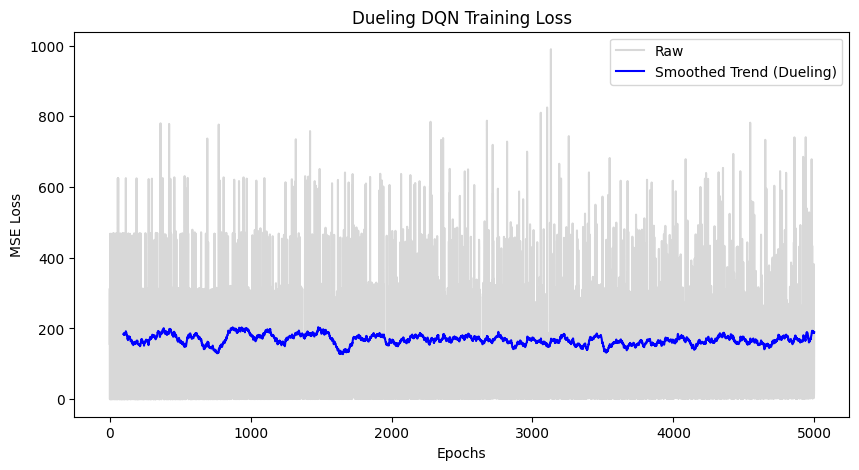

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm

print("--- Step 4: Training with Soft Updates ---")

losses = []
NUM_EPOCHS = 5000 

pbar = tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")

for epoch in pbar:
    # 1. Sample
    states, actions, rewards, next_states, dones = buffer.sample()
    
    # 2. Compute Q(s,a)
    q_values = policy_net(states).gather(1, actions)
    
    # 3. Compute Target Q (Double DQN)
    with torch.no_grad():
        next_actions = policy_net(next_states).argmax(1, keepdim=True)
        next_q_values = target_net(next_states).gather(1, next_actions)
        target_q = rewards + (1 - dones) * GAMMA * next_q_values
        
    # 4. Optimize
    loss = nn.MSELoss()(q_values, target_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    # --- NEW: SOFT UPDATE ---
    # Target = TAU * Policy + (1 - TAU) * Target
    # This stabilizes training massively
    for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)
    
    if epoch % 100 == 0:
        pbar.set_postfix({'Loss': f"{loss.item():.4f}"})

# Smoothing
loss_series = pd.Series(losses)
smooth_loss = loss_series.rolling(window=100).mean()

plt.figure(figsize=(10, 5))
plt.plot(losses, alpha=0.3, color='gray', label='Raw')
plt.plot(smooth_loss, alpha=1.0, color='blue', label='Smoothed Trend (Dueling)')
plt.title("Dueling DQN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

--- Step 5: Generating AI Policy 3D Plot (Nature Style) ---


/var/tmp/pbs.1221323.pbs-7/ipykernel_1823329/2838338897.py:103: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


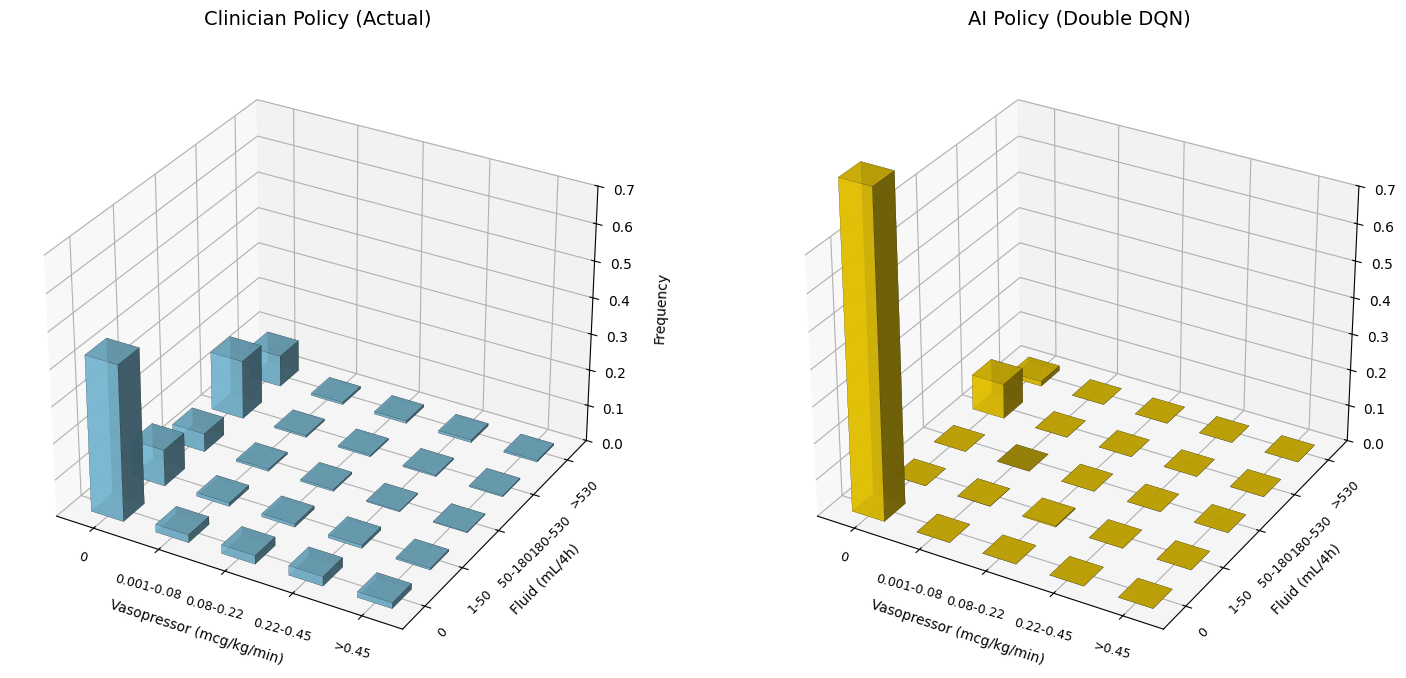

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print("--- Step 5: Generating AI Policy 3D Plot (Nature Style) ---")

def plot_policy_comparison(model, df):
    # 1. PREPARE DATA
    # --------------------------------
    # A. Clinician Actions (Real History)
    doc_actions = df['action'].values
    
    # B. AI Actions (Predicted Policy)
    model.eval()
    with torch.no_grad():
        # Move state data to GPU
        states = torch.tensor(df[['HR', 'SysBP', 'SpO2']].values, dtype=torch.float32).to(device)
        
        ai_actions = []
        # Batch inference to prevent memory overflow
        batch_size = 4096
        for i in range(0, len(states), batch_size):
            batch = states[i : i + batch_size]
            q_values = model(batch)
            # Select action with highest Q-value
            ai_actions.extend(q_values.argmax(dim=1).cpu().numpy())
            
    ai_actions = np.array(ai_actions)

    # 2. HELPER: UNPACK BINS
    # --------------------------------
    # Action Index (0-24) -> Fluid Bin (0-4) & Vaso Bin (0-4)
    # Mapping matches the Step 2 thresholds
    def unpack(action_list):
        fluid = action_list // 5
        vaso = action_list % 5
        return fluid, vaso

    doc_fluid, doc_vaso = unpack(doc_actions)
    ai_fluid, ai_vaso = unpack(ai_actions)

    # 3. SETUP PLOT
    # --------------------------------
    # Labels matching Komorowski et al. (2018)
    fluid_labels = ["0", "1-50", "50-180", "180-530", ">530"]
    vaso_labels = ["0", "0.001-0.08", "0.08-0.22", "0.22-0.45", ">0.45"]
    
    # Grid Setup
    x_edges = np.arange(6) - 0.5
    y_edges = np.arange(6) - 0.5
    xpos, ypos = np.meshgrid(x_edges[:-1] + 0.25, y_edges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    dx = dy = 0.5

    # Create Figure
    fig = plt.figure(figsize=(18, 8))

    # 4. PLOT CLINICIAN (LEFT)
    # --------------------------------
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Histogram: Vaso on X, Fluid on Y
    hist_doc, _, _ = np.histogram2d(doc_vaso, doc_fluid, bins=[x_edges, y_edges], density=True)
    dz_doc = hist_doc.ravel()
    
    ax1.bar3d(xpos, ypos, zpos, dx, dy, dz_doc, zsort='average', color='skyblue', alpha=0.8, edgecolor='k', linewidth=0.1)
    ax1.set_title("Clinician Policy (Actual)", fontsize=14, pad=20)
    ax1.set_xlabel("Vasopressor (mcg/kg/min)", labelpad=10)
    ax1.set_ylabel("Fluid (mL/4h)", labelpad=10)
    ax1.set_zlabel("Frequency", labelpad=10)
    ax1.set_zlim(0, 0.7) # Fixed height for comparison

    # Ticks
    ax1.set_xticks(np.arange(5))
    ax1.set_xticklabels(vaso_labels, rotation=-15, fontsize=9)
    ax1.set_yticks(np.arange(5))
    ax1.set_yticklabels(fluid_labels, rotation=45, fontsize=9)

    # 5. PLOT AI AGENT (RIGHT)
    # --------------------------------
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Histogram
    hist_ai, _, _ = np.histogram2d(ai_vaso, ai_fluid, bins=[x_edges, y_edges], density=True)
    dz_ai = hist_ai.ravel()
    
    # Gold color for AI
    ax2.bar3d(xpos, ypos, zpos, dx, dy, dz_ai, zsort='average', color='gold', alpha=0.8, edgecolor='k', linewidth=0.1)
    ax2.set_title("AI Policy (Double DQN)", fontsize=14, pad=20)
    ax2.set_xlabel("Vasopressor (mcg/kg/min)", labelpad=10)
    ax2.set_ylabel("Fluid (mL/4h)", labelpad=10)
    ax2.set_zlabel("Frequency", labelpad=10)
    ax2.set_zlim(0, 0.7)

    # Ticks
    ax2.set_xticks(np.arange(5))
    ax2.set_xticklabels(vaso_labels, rotation=-15, fontsize=9)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(fluid_labels, rotation=45, fontsize=9)

    plt.tight_layout()
    plt.show()

# Run the comparison
plot_policy_comparison(policy_net, df_main)

--- Generating Split Mortality U-Curves (Paper Figs 2d & 2e) ---


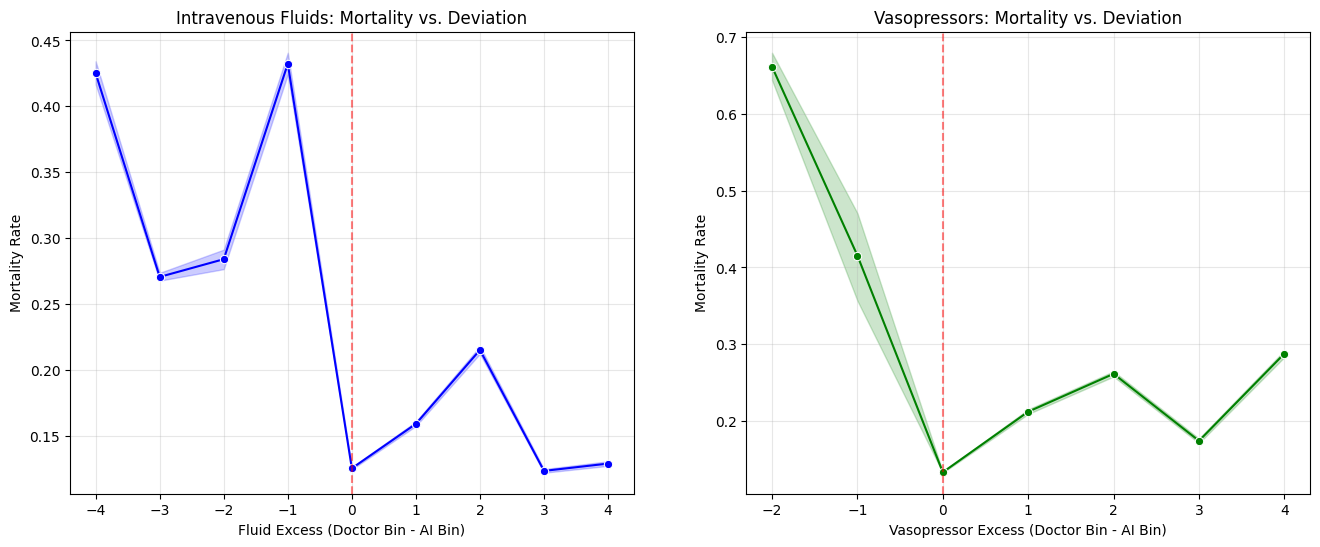

In [7]:
import seaborn as sns

print("--- Generating Split Mortality U-Curves (Paper Figs 2d & 2e) ---")

def plot_split_u_curves(model, df):
    # 1. Get Actions again
    doc_actions = df['action'].values
    
    model.eval()
    with torch.no_grad():
        states = torch.tensor(df[['HR', 'SysBP', 'SpO2']].values, dtype=torch.float32).to(device)
        ai_actions = []
        for i in range(0, len(states), 4096):
            ai_actions.extend(model(states[i : i+4096]).argmax(dim=1).cpu().numpy())
    ai_actions = np.array(ai_actions)
    
    # 2. Unpack
    doc_fluid, doc_vaso = doc_actions // 5, doc_actions % 5
    ai_fluid, ai_vaso = ai_actions // 5, ai_actions % 5
    
    # 3. Calculate "Dose Excess" (Doctor - AI)
    fluid_excess = doc_fluid - ai_fluid
    vaso_excess = doc_vaso - ai_vaso
    
    # 4. Prepare DataFrame for plotting
    df_res = pd.DataFrame({
        'fluid_excess': fluid_excess,
        'vaso_excess': vaso_excess,
        'is_dead': df['outcome_reward'].apply(lambda x: 1 if x == -100 else 0)
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Fluid Curve ---
    # We use seaborn lineplot which automatically calculates confidence intervals (shadow)
    sns.lineplot(data=df_res, x='fluid_excess', y='is_dead', ax=axes[0], color='blue', marker='o')
    axes[0].set_title("Intravenous Fluids: Mortality vs. Deviation")
    axes[0].set_xlabel("Fluid Excess (Doctor Bin - AI Bin)")
    axes[0].set_ylabel("Mortality Rate")
    axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, label="Agreement")
    axes[0].grid(True, alpha=0.3)
    
    # --- Vasopressor Curve ---
    sns.lineplot(data=df_res, x='vaso_excess', y='is_dead', ax=axes[1], color='green', marker='o')
    axes[1].set_title("Vasopressors: Mortality vs. Deviation")
    axes[1].set_xlabel("Vasopressor Excess (Doctor Bin - AI Bin)")
    axes[1].set_ylabel("Mortality Rate")
    axes[1].axvline(0, color='red', linestyle='--', alpha=0.5, label="Agreement")
    axes[1].grid(True, alpha=0.3)
    
    plt.show()

plot_split_u_curves(policy_net, df_main)

In [8]:
import pandas as pd
import numpy as np
import torch

print("--- Generating Dosage Count Tables ---")

def print_detailed_dosage_tables(model, df):
    # 1. SETUP LABELS (Matching Nature Paper)
    fluid_labels = ["0", "1-50", "50-180", "180-530", ">530"]
    vaso_labels = ["0", "0.001-0.08", "0.08-0.22", "0.22-0.45", ">0.45"]
    
    # 2. PREPARE CLINICIAN DATA
    doc_actions = df['action'].values
    doc_fluid = doc_actions // 5
    doc_vaso = doc_actions % 5
    
    # 3. PREPARE AI DATA
    model.eval()
    with torch.no_grad():
        states = torch.tensor(df[['HR', 'SysBP', 'SpO2']].values, dtype=torch.float32).to(device)
        ai_actions = []
        # Batch processing
        for i in range(0, len(states), 4096):
            batch = states[i : i + 4096]
            ai_actions.extend(model(batch).argmax(dim=1).cpu().numpy())
    ai_actions = np.array(ai_actions)
    ai_fluid = ai_actions // 5
    ai_vaso = ai_actions % 5

    # 4. GENERATE TABLES (Using Pandas Crosstab)
    
    # --- CLINICIAN TABLE ---
    df_doc = pd.DataFrame({'Fluid': doc_fluid, 'Vaso': doc_vaso})
    # Replace bins with text labels
    df_doc['Fluid_Label'] = df_doc['Fluid'].replace(dict(enumerate(fluid_labels)))
    df_doc['Vaso_Label'] = df_doc['Vaso'].replace(dict(enumerate(vaso_labels)))
    
    print("\n=======================================================")
    print("TABLE 1: CLINICIAN POLICY (Actual Patient Counts)")
    print("=======================================================")
    print("Rows: Fluid Dose (mL/4h) | Cols: Vasopressor Dose (mcg/kg/min)")
    print("-------------------------------------------------------")
    
    # Create Cross-tabulation (Counts)
    tab_doc = pd.crosstab(df_doc['Fluid_Label'], df_doc['Vaso_Label'])
    # Reorder to ensure correct sorting (0 to Max) instead of alphabetical
    tab_doc = tab_doc.reindex(index=fluid_labels, columns=vaso_labels, fill_value=0)
    display(tab_doc)
    
    # --- AI TABLE ---
    df_ai = pd.DataFrame({'Fluid': ai_fluid, 'Vaso': ai_vaso})
    df_ai['Fluid_Label'] = df_ai['Fluid'].replace(dict(enumerate(fluid_labels)))
    df_ai['Vaso_Label'] = df_ai['Vaso'].replace(dict(enumerate(vaso_labels)))
    
    print("\n\n=======================================================")
    print("TABLE 2: AI POLICY (Predicted Action Counts)")
    print("=======================================================")
    print("Rows: Fluid Dose (mL/4h) | Cols: Vasopressor Dose (mcg/kg/min)")
    print("-------------------------------------------------------")
    
    tab_ai = pd.crosstab(df_ai['Fluid_Label'], df_ai['Vaso_Label'])
    tab_ai = tab_ai.reindex(index=fluid_labels, columns=vaso_labels, fill_value=0)
    display(tab_ai)

    # --- PERCENTAGE TABLE (OPTIONAL BUT USEFUL) ---
    print("\n\n=======================================================")
    print("TABLE 3: COMPARISON (AI % - Clinician %)")
    print("=======================================================")
    print("Positive values = AI does this MORE. Negative = AI does this LESS.")
    
    # Calculate percentages
    pct_doc = (tab_doc / len(df)) * 100
    pct_ai = (tab_ai / len(df)) * 100
    diff = pct_ai - pct_doc
    
    # Format as string with % sign
    display(diff.style.format("{:+.1f}%").background_gradient(cmap='coolwarm', axis=None))

# Run the function
print_detailed_dosage_tables(policy_net, df_main)

--- Generating Dosage Count Tables ---

TABLE 1: CLINICIAN POLICY (Actual Patient Counts)
Rows: Fluid Dose (mL/4h) | Cols: Vasopressor Dose (mcg/kg/min)
-------------------------------------------------------


Vaso_Label,0,0.001-0.08,0.08-0.22,0.22-0.45,>0.45
Fluid_Label,,,,,
0,592319,29512,32462,36085,21238
1-50,138955,13061,11753,11482,6578
50-180,69436,7634,6952,3604,3025
180-530,225520,6654,5992,5309,4349
>530,120547,8680,9380,9302,5998




TABLE 2: AI POLICY (Predicted Action Counts)
Rows: Fluid Dose (mL/4h) | Cols: Vasopressor Dose (mcg/kg/min)
-------------------------------------------------------


Vaso_Label,0,0.001-0.08,0.08-0.22,0.22-0.45,>0.45
Fluid_Label,,,,,
0,1228115,0,0,0,0
1-50,0,174,4182,0,0
50-180,0,0,0,0,0
180-530,134829,0,0,0,0
>530,18527,0,0,0,0




TABLE 3: COMPARISON (AI % - Clinician %)
Positive values = AI does this MORE. Negative = AI does this LESS.


Vaso_Label,0,0.001-0.08,0.08-0.22,0.22-0.45,>0.45
Fluid_Label,,,,,
0,+45.9%,-2.1%,-2.3%,-2.6%,-1.5%
1-50,-10.0%,-0.9%,-0.5%,-0.8%,-0.5%
50-180,-5.0%,-0.6%,-0.5%,-0.3%,-0.2%
180-530,-6.5%,-0.5%,-0.4%,-0.4%,-0.3%
>530,-7.4%,-0.6%,-0.7%,-0.7%,-0.4%
